In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg                  # write image to folder
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # used for data augmentation when working with image data
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# take a look at the size of the dataset
test_normal_folder=os.listdir('/content/drive/MyDrive/chest_xray/test/NORMAL')
test_pneumonia_folder=os.listdir('/content/drive/MyDrive/chest_xray/test/PNEUMONIA')
train_normal_folder=os.listdir('/content/drive/MyDrive/chest_xray/train/NORMAL')
train_pneumonia_folder=os.listdir('/content/drive/MyDrive/chest_xray/train/PNEUMONIA')
val_normal_folder=os.listdir('/content/drive/MyDrive/chest_xray/val/NORMAL')
val_pneumonia_folder=os.listdir('/content/drive/MyDrive/chest_xray/val/PNEUMONIA')

len(test_normal_folder),len(test_pneumonia_folder),len(train_normal_folder),len(train_pneumonia_folder),len(val_normal_folder),len(val_pneumonia_folder)

(234, 390, 1351, 3885, 8, 8)

In [ ]:
# create a dataframe to store image path and their corresponding labels.
df = pd.DataFrame(columns=['path', 'label'])

In [ ]:
# total length of the dataset
len(test_normal_folder)+len(test_pneumonia_folder)+len(train_normal_folder)+len(train_pneumonia_folder)+len(val_normal_folder)+len(val_pneumonia_folder)

5876

In [ ]:
# adding value to path column in dataframe df.
df = pd.DataFrame(columns=['path'])
main_path='/content/drive/MyDrive/chest_xray'
for i in ['test','train','val']:
    for j in ['NORMAL','PNEUMONIA']:
        sub_list=os.listdir(f'{main_path}/{i}/{j}')
        path_list=[f'{main_path}/{i}/{j}/{x}' for x in sub_list]
        new_df = pd.DataFrame(path_list, columns=['path'])
        df = pd.concat([df,new_df],ignore_index=True)

In [ ]:
df.head()


,path
0,/content/drive/MyDrive/chest_xray/test/NORMAL/...
1,/content/drive/MyDrive/chest_xray/test/NORMAL/...
2,/content/drive/MyDrive/chest_xray/test/NORMAL/...
3,/content/drive/MyDrive/chest_xray/test/NORMAL/...
4,/content/drive/MyDrive/chest_xray/test/NORMAL/...


In [ ]:
# adding value to label column in dataframe df.
df['label']=df['path'].str.split('/').str[-2]

In [ ]:
df.head()

,path,label
0,/content/drive/MyDrive/chest_xray/test/NORMAL/...,NORMAL
1,/content/drive/MyDrive/chest_xray/test/NORMAL/...,NORMAL
2,/content/drive/MyDrive/chest_xray/test/NORMAL/...,NORMAL
3,/content/drive/MyDrive/chest_xray/test/NORMAL/...,NORMAL
4,/content/drive/MyDrive/chest_xray/test/NORMAL/...,NORMAL


In [ ]:
# add a new column folder to chech if we have correctly made the dataframe
df['folder']=df['path'].str.split('/').str[-3]

In [ ]:
# all the data maches correctly as earlier.
print('test_normal',len(df.query('folder == "test" and label=="NORMAL"')))
print('test_pneumonia',len(df.query('folder == "test" and label=="PNEUMONIA"')))
print('train_normal',len(df.query('folder == "train" and label=="NORMAL"')))
print('train_pneumonia',len(df.query('folder == "train" and label=="PNEUMONIA"')))

test_normal 234
test_pneumonia 390
train_normal 1351
train_pneumonia 3885


In [ ]:
# check the size of the dataset and value count
len(df),df.label.value_counts()

(5876,
 PNEUMONIA    4283
 NORMAL       1593
 Name: label, dtype: int64)

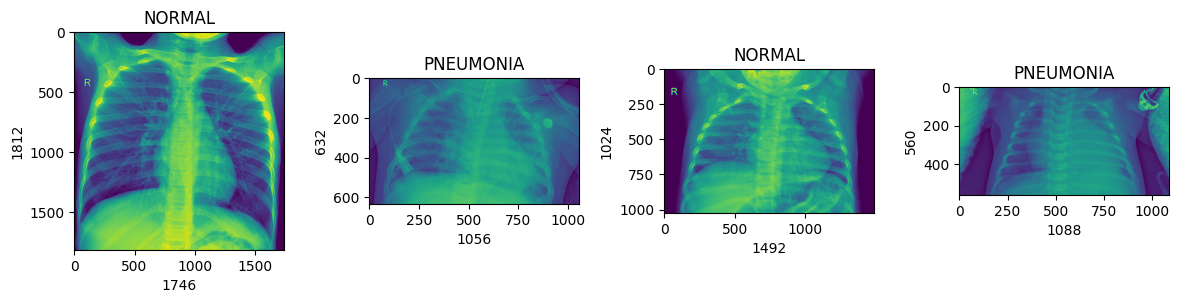

In [ ]:
# lets take a look at some of the images at random
plt.figure(figsize=(12,12))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.tight_layout()
    path=df.path.sample(n=1).values[0]
    ran_img=imread(path)
    plt.imshow(ran_img)
    plt.title(df.query('path == @path').label.item())
    plt.xlabel(ran_img.shape[1], fontsize=10)
    plt.ylabel(ran_img.shape[0], fontsize=10)

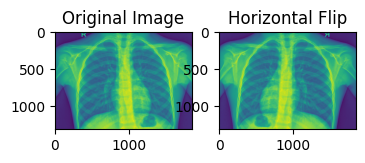

In [ ]:
# sample example of data transformation

image_path = '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
image = imread(image_path)
#  Display the original image
plt.figure(figsize=(6, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)

# Horizontal flip (left to right)
horizontal_flip = np.flip(image, axis=1)

# Display the horizontally flipped image
plt.subplot(1, 3, 2)
plt.title("Horizontal Flip")
plt.imshow(horizontal_flip)

In [ ]:
# copy rows with NORMAL as label
df_normal=df.query('label=="NORMAL"')
df_normal.head(10),df_normal.shape


(                                                path   label folder
 0  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 1  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 2  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 3  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 4  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 5  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 6  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 7  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 8  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test
 9  /content/drive/MyDrive/chest_xray/test/NORMAL/...  NORMAL   test,
 (1593, 3))

In [ ]:
folder_name = 'balancing_image'
folder_path = os.path.join(os.getcwd(), folder_name)
os.makedirs(folder_path, exist_ok=True)

In [ ]:
# transforming each image and storing it in the folder created
n=0
for path in tqdm(df_normal.path.values):
    image = imread(path)
    horizontal_flip = np.flip(image, axis=1)
    # Specify the output file path and name for the flipped image
    output_image_path = f'/content/balancing_image/normal{n}.jpeg'
    # Save the horizontally flipped image using mpimg.imsave()
    n=n+1
    mpimg.imsave(output_image_path, horizontal_flip)

100%|██████████| 1593/1593 [08:33<00:00,  3.10it/s]


In [ ]:
# os.remove(image_path)

# checking the size and name's of the image
flip_img_list=os.listdir('/content/balancing_image')
len(flip_img_list),flip_img_list[:2]

(1593, ['normal1172.jpeg', 'normal425.jpeg'])

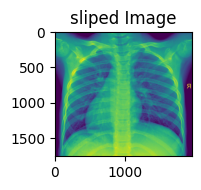

In [ ]:
# take a look at the sliped image
image_path = '/content/balancing_image/normal1005.jpeg'
image = imread(image_path)
plt.figure(figsize=(6, 6))
plt.subplot(1, 3, 1)
plt.title("sliped Image")
plt.imshow(image)

In [ ]:
# modifing the paths of the transformed data to add it to the datafrane df
preffix='/content/balancing_image'
path_list = [preffix+item for item in flip_img_list]
# path_list[:10]
new_df = pd.DataFrame(path_list, columns=['path'])
new_df['label']='NORMAL'
new_df.head(5)

,path,label
0,/content/balancing_imagenormal1172.jpeg,NORMAL
1,/content/balancing_imagenormal425.jpeg,NORMAL
2,/content/balancing_imagenormal551.jpeg,NORMAL
3,/content/balancing_imagenormal1376.jpeg,NORMAL
4,/content/balancing_imagenormal881.jpeg,NORMAL


In [ ]:
df = pd.concat([df,new_df],ignore_index=True)
# take a look at the size of the dataset and valuecount of the label
len(df),df.label.value_counts()

(7469,
 PNEUMONIA    4283
 NORMAL       3186
 Name: label, dtype: int64)

In [ ]:
# no need of this column only used for checking
df.drop('folder',axis=1,inplace=True)

In [ ]:
# spliting the data to train(70%),test(10%), val(20%)
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.18, random_state=42)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
train.label.value_counts(),test.label.value_counts()


(PNEUMONIA    3175
 NORMAL       2337
 Name: label, dtype: int64,
 PNEUMONIA    408
 NORMAL       339
 Name: label, dtype: int64)

In [ ]:
# train, val and test size
len(train),len(val),len(test)

(5512, 1210, 747)

In [ ]:
# Create Image Data Generator for Train Set,val set and test set
train_data_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
val_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
      dataframe=train,
      x_col='path',
      y_col='label',
      color_mode='grayscale',
      class_mode='binary',
      batch_size=32
      )
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col='label',
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='label',
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 4375 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1137 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 927 validated image filenames belonging to 2 classes.
Found 574 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 283 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 173 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
train_generator.image_shape,train_generator.labels.count(1)

((256, 256, 1), 3175)

In [ ]:
# shape of image in val and also size of val
val_generator.image_shape,val_generator.labels.count(0)+val_generator.labels.count(1)

((256, 256, 1), 927)

**CNN Model**

In [ ]:
# create the cnn model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'sigmoid', units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

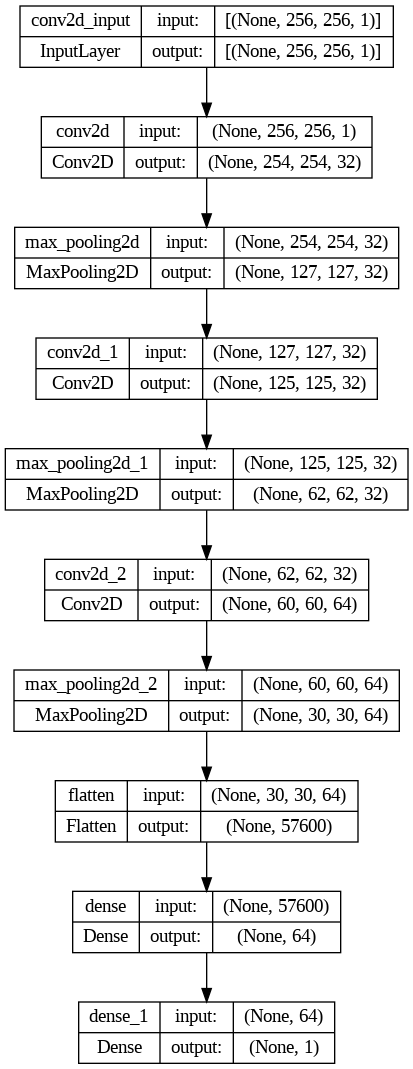

In [ ]:
# plot the model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history=model.fit(train_generator,epochs=10, validation_data=val_generator, callbacks=[early_stopping_callback])

Epoch 1/10
137/137 [==============================] - 871s 6s/step - loss: 0.3460 - accuracy: 0.8414 - val_loss: 0.2674 - val_accuracy: 0.9061
Epoch 2/10
137/137 [==============================] - 423s 3s/step - loss: 0.2561 - accuracy: 0.8923 - val_loss: 0.1760 - val_accuracy: 0.9407
Epoch 3/10
137/137 [==============================] - 436s 3s/step - loss: 0.2359 - accuracy: 0.9054 - val_loss: 0.2023 - val_accuracy: 0.9374
Epoch 4/10
137/137 [==============================] - 414s 3s/step - loss: 0.2176 - accuracy: 0.9207 - val_loss: 0.1728 - val_accuracy: 0.9385
Epoch 5/10
137/137 [==============================] - 439s 3s/step - loss: 0.1892 - accuracy: 0.9305 - val_loss: 0.1826 - val_accuracy: 0.9428
Epoch 6/10
137/137 [==============================] - 446s 3s/step - loss: 0.1822 - accuracy: 0.9344 - val_loss: 0.1736 - val_accuracy: 0.9428
Epoch 7/10
137/137 [==============================] - 439s 3s/step - loss: 0.1677 - accuracy: 0.9378 - val_loss: 0.1679 - val_accuracy: 0.9342

In [ ]:
# convert model evaluatoin to dataframe for ploting
re = pd.DataFrame(history.history)
re.head()

,loss,accuracy,val_loss,val_accuracy
0,0.346029,0.841371,0.267390,0.906149
1,0.256087,0.892343,0.175955,0.940669
2,0.235924,0.905371,0.202320,0.937433
3,0.217589,0.920686,0.172800,0.938511
4,0.189240,0.930514,0.182615,0.942826


In [ ]:
# evaluate model with test data
test_accu = model.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')
# lets manually evaluate the test data
preds = model.predict(test_generator,verbose=1)

18/18 [==============================] - 101s 6s/step - loss: 0.1709 - accuracy: 0.9355
The testing accuracy is : 93.55400800704956 %
18/18 [==============================] - 16s 847ms/step


In [ ]:
# converting the prediction in preds to labels
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
# take a look at y_pred,y_actual
predictions.flatten().tolist()[:5] , test_generator.classes[:5]

([0.0, 1.0, 0.0, 1.0, 1.0], [0, 1, 0, 1, 0])

In [ ]:
# check accuracy of test_predicted and test_actual with accuracy_score()
accuracy = accuracy_score(test_generator.classes, predictions.flatten().tolist())
print("Accuracy:", accuracy)

Accuracy: 0.9355400696864111


<Axes: >

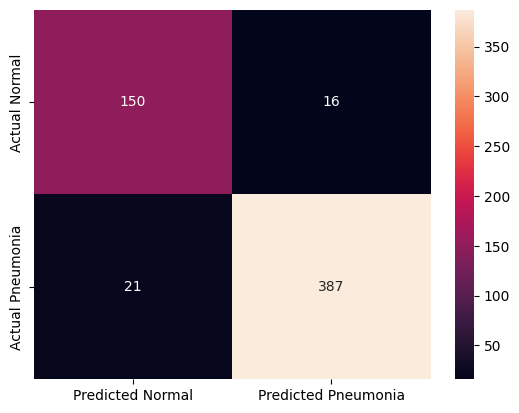

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

<Axes: >

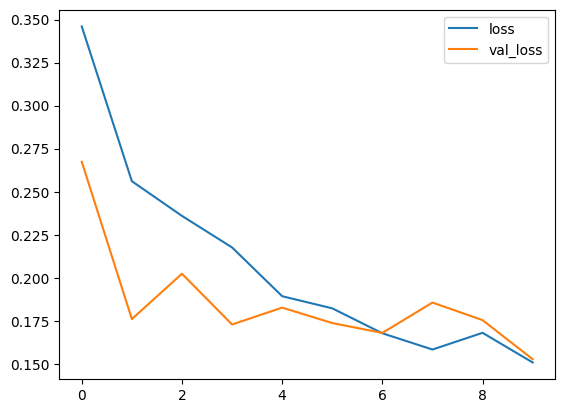

In [ ]:
re[['loss','val_loss']].plot()

<Axes: >

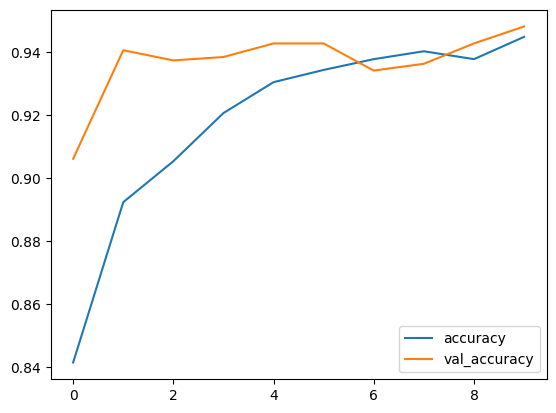

In [ ]:
re[['accuracy','val_accuracy']].plot()